In [1]:
# Install library for reading JPK File
%pip uninstall jpkreader --yes
%pip install git+https://github.com/jlopezalo/pyjpkreader

Found existing installation: jpkreader 0.0.1
Uninstalling jpkreader-0.0.1:
  Successfully uninstalled jpkreader-0.0.1
Note: you may need to restart the kernel to use updated packages.
  Cloning https://github.com/jlopezalo/pyjpkreader to /private/var/folders/4k/ps22fmxj3gx6vls78t2p63wh0000gn/T/pip-req-build-077o9bde
  Running command git clone -q https://github.com/jlopezalo/pyjpkreader /private/var/folders/4k/ps22fmxj3gx6vls78t2p63wh0000gn/T/pip-req-build-077o9bde
  Created wheel for jpkreader: filename=jpkreader-0.0.1-py3-none-any.whl size=10194 sha256=0d8864fdea4a04490bb1f834f842a4d9a9237aaee032c3f196fb0f3596aab653
  Stored in directory: /private/var/folders/4k/ps22fmxj3gx6vls78t2p63wh0000gn/T/pip-ephem-wheel-cache-fwnjukn9/wheels/23/c0/8e/c378f28c65b0199f6092b6aa45e090c1ed6b4093f3adb03a15
Successfully built jpkreader
Note: you may need to restart the kernel to use updated packages.


In [2]:
# Install library for AFM data Rheology Analysis
%pip uninstall pyafmrheo --yes
%pip install git+https://github.com/jlopezalo/pyafmrheo.git

Found existing installation: pyafmrheo 0.0.1
Uninstalling pyafmrheo-0.0.1:
  Successfully uninstalled pyafmrheo-0.0.1
Note: you may need to restart the kernel to use updated packages.
  Cloning https://github.com/jlopezalo/pyafmrheo.git to /private/var/folders/4k/ps22fmxj3gx6vls78t2p63wh0000gn/T/pip-req-build-7g_y0bvq
  Running command git clone -q https://github.com/jlopezalo/pyafmrheo.git /private/var/folders/4k/ps22fmxj3gx6vls78t2p63wh0000gn/T/pip-req-build-7g_y0bvq
  Created wheel for pyafmrheo: filename=pyafmrheo-0.0.1-py3-none-any.whl size=15038 sha256=78731eb5b32df0dd5d067124060075574688b9711f9d3ec7aae5c699438a8e0b
  Stored in directory: /private/var/folders/4k/ps22fmxj3gx6vls78t2p63wh0000gn/T/pip-ephem-wheel-cache-_db94rzd/wheels/fb/66/18/3e93b45c845b0d7b83ded1e127a1c127820d070ce5b71dece4
Successfully built pyafmrheo
Note: you may need to restart the kernel to use updated packages.


In [3]:
# Install SciPy library for signal processing
%pip install scipy

Note: you may need to restart the kernel to use updated packages.


In [4]:
# Install lmfit for leastsq fitting
%pip install lmfit

Note: you may need to restart the kernel to use updated packages.


In [5]:
# Import libraries we will need
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import detrend

# Get file reader from library
from jpkreader import load_jpk_file

# Get data analysis tools
from pyafmrheo.utils.force_curves import *
from pyafmrheo.hertz_fit import HertzFit

In [6]:
# Define global variables
file_path = '/Users/javierlopez/Documents/Marseille/05-11-2021/E/map-data-2021.11.05-15.41.45.699.jpk-force-map'
# Shapes available: paraboloid, pyramid
indenter_shape = "pyramid"
# tip_parameter = 500 * 1e-9 # meters
tip_parameter = 35 # degrees
# Poisson ratio
poisson_ratio = 0.5
# If None it will use the deflection sensitivity from the file
deflection_sensitivity = None # m/V
# If None it will use the spring constant from the file
spring_constant = None # N/m
# General plotting params
plt.rcParams["figure.figsize"] = (10,5)

In [7]:
file = load_jpk_file(file_path)

In [8]:
file_id = file.file_id
file_type = file.file_type
file_metadata = file.file_metadata
file_data = file.data
piezo_image = file.piezo_image
quality_map = file.quality_map

In [9]:
closed_loop = file_metadata['z_closed_loop_status']
file_deflection_sensitivity = file_metadata['original_deflection_sensitivity'] #nm/V
file_spring_constant = file_metadata['original_spring_constant'] #N/m
height_channel = file_metadata['height_channel_key']

if not deflection_sensitivity: deflection_sensitivity = file_deflection_sensitivity / 1e9 #m/V
if not spring_constant: spring_constant = file_spring_constant

In [10]:
curve_idx = 0
force_curve = file_data[curve_idx]
extend_segments = force_curve.extend_segments
pause_segments = force_curve.pause_segments
modulation_segments = force_curve.modulation_segments
retract_segments = force_curve.retract_segments
force_curve_segments = [*extend_segments, *pause_segments, *modulation_segments, *retract_segments]
force_curve_segments = sorted(force_curve_segments, key=lambda x: int(x[0]))

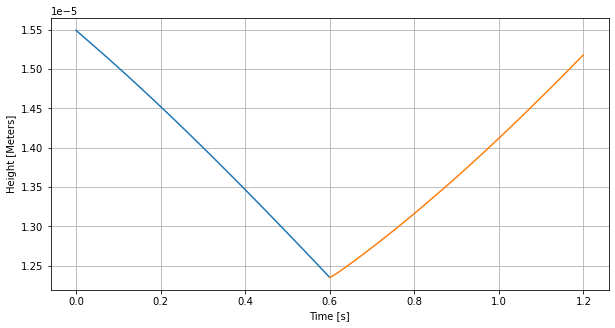

In [11]:
t0 = 0
for seg_id, segment in force_curve_segments:
    height = segment.segment_formated_data[height_channel]
    time = segment.segment_formated_data["time"] + t0
    plt.plot(time, height)
    t0 = time[-1]

plt.xlabel("Time [s]")
plt.ylabel("Height [Meters]")
plt.grid()
plt.show()

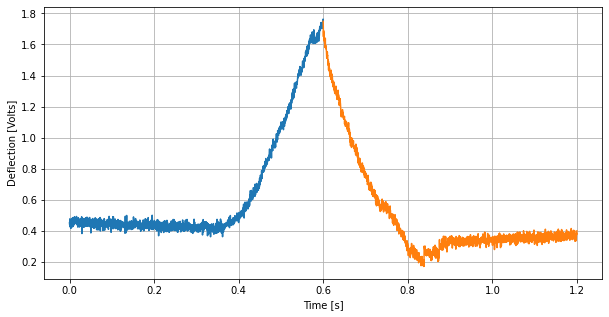

In [12]:
t0 = 0
for seg_id, segment in force_curve_segments:
    deflection = segment.segment_formated_data["vDeflection"]
    time = segment.segment_formated_data["time"] + t0
    plt.plot(time, deflection)
    t0 = time[-1]

plt.xlabel("Time [s]")
plt.ylabel("Deflection [Volts]")
plt.grid()
plt.show()

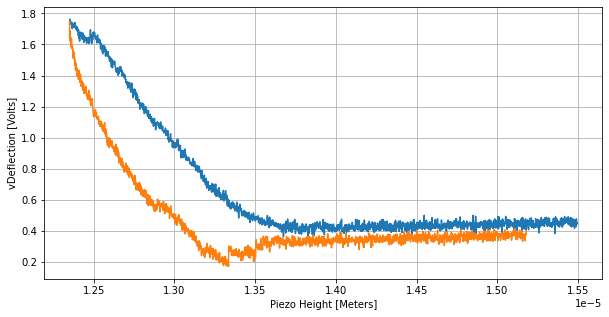

In [13]:
for seg_id, segment in force_curve_segments:
    height = segment.segment_formated_data[height_channel]
    deflection = segment.segment_formated_data["vDeflection"]
    plt.plot(height, deflection)

plt.xlabel("Piezo Height [Meters]")
plt.ylabel("vDeflection [Volts]")
plt.grid()
plt.show()

In [14]:
# Get approach, first extend segment
first_exted_seg_id, first_ext_seg = extend_segments[0]
app_deflection, app_height, app_time =\
    preprocess_segment(first_ext_seg, height_channel, deflection_sensitivity)

# Get retract, last retract segment
last_ret_seg_id, last_ret_seg = retract_segments[-1]
ret_deflection, ret_height, ret_time =\
    preprocess_segment(last_ret_seg, height_channel, deflection_sensitivity)

In [15]:
# Shift height
xzero = ret_height[-1] # Maximum height
app_height = xzero - app_height
ret_height = xzero - ret_height

In [16]:
# Find initial PoC, you may get some warnings.
poc = get_poc_RoV_method(app_height, app_deflection, win_size=60)
print(*poc)

/opt/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3702: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:221: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


1.5863563987854109e-06 1.375145042506078e-09


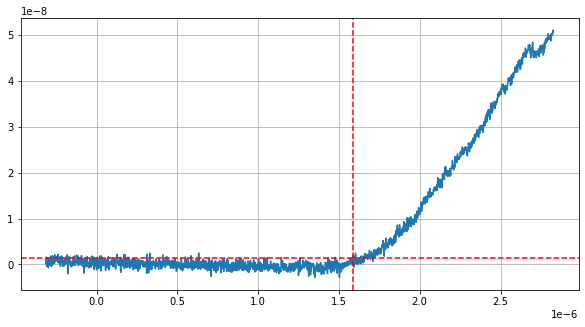

In [17]:
plt.plot(app_height, app_deflection)
plt.axvline(x=poc[0], color='r', linestyle='--')
plt.axhline(y=poc[1], color='r', linestyle='--')
plt.grid()
plt.show()

In [1]:
# Hertz fit
poc[1] = 0
app_indentation, app_force = get_force_vs_indentation_curve(app_height, app_deflection, poc, spring_constant)

# Initial parameters
# delta0, f0, slope, E0
p0 = [0, 0, 0, 1000]

hertz_result = HertzFit(app_indentation, app_force, indenter_shape, tip_parameter, p0, poisson_ratio)

hertz_E = hertz_result.best_values['E0']
hertz_d0 = hertz_result.best_values['delta0']

print(hertz_result.fit_report())

# Plot Hertz Fit results
plt.plot(app_indentation, app_force)
plt.plot(app_indentation, hertz_result.best_fit)
plt.xlabel('Indentation [m]')
plt.ylabel('Force [N]')
plt.grid()
plt.show()

NameError: name 'poc' is not defined